# Global Flood Database Sampling Accuracies

In [28]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import os
import glob
import datetime
#import pylabb
import matplotlib as plt
import datetime as datetime  
import statsmodels.api as sm  
import matplotlib.pyplot as plt
import seaborn as sns
import random


In [29]:
%matplotlib inline

In [30]:
#df = pd.read_csv('/Users/ckuhn/Documents/Coauthor/DFO_Accuracy/student_data/all_student_data.csv', low_memory=False)
df = pd.read_csv('/Users/ckuhn/Desktop/gfd_accuracy_rename/all_student_data.csv', low_memory=False)

In [31]:
raw = df.copy()
raw.head(1)

,Unnamed: 0,B1,B2,B3,B4,B5,B7,MNDWI,NDVI,analyst,date,dfoID,id,lat,lon,random,strata,validation,score
0,0,408.413014,568.694058,460.692907,2364.987499,1356.32336,676.680458,-0.610643,0.672432,SiL,08/15/2018,2570,0,22.68277,87.928441,0.308501,0,0.0,0.0


In [32]:
raw.columns

Index([u'Unnamed: 0', u'B1', u'B2', u'B3', u'B4', u'B5', u'B7', u'MNDWI',
       u'NDVI', u'analyst', u'date', u'dfoID', u'id', u'lat', u'lon',
       u'random', u'strata', u'validation', u'score'],
      dtype='object')

In [33]:
#list(set(raw.dfoID))

In [34]:
#raw.groupby(['dfoID'])['strata'].count()

In [35]:
raw.groupby(['strata'])['dfoID'].count()
# strata = 0 = dry, 1 = permanent water, 2 = flood

strata
0    4469
2    4504
4    9558
Name: dfoID, dtype: int64

In [36]:
raw.groupby(['validation'])['dfoID'].count()
## about 266 -99 values

validation
0.0     7365
1.0    11166
Name: dfoID, dtype: int64

### This is to drop floods with not enough points for the test

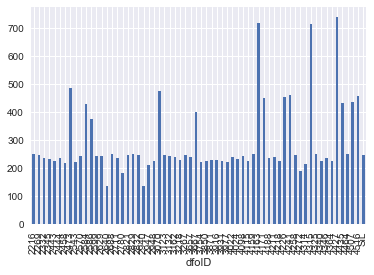

In [37]:
raw.groupby(['dfoID'])['score'].count().plot(kind='bar')

In [42]:
raw2 = raw.groupby('dfoID').filter(lambda g: g.dfoID.count() > 200)
raw2.dfoID.unique()

array(['2570', '4314', '2586', '4098', '4315', '3218', '4507', '2443',
       'SiL', '3123', '2599', '4346', '2688', '4211', '4516', '4188',
       '4258', '4171', '4435', '4022', '2332', '2345', '4159', '3754',
       '3871', '2832', '2829', '4427', '3267', '4226', '4241', '2948',
       '3667', '2444', '3132', '4218', '2711', '2458', '4364', '2584',
       '2216', '3162', '2543', '2473', '2821', '3850', '3916', '2947',
       '3977', '4115', '4024', '4464', '3931', '3657', '2629', '4340',
       '4163', '2269', '4325', '3070'], dtype=object)

In [41]:
# These are the ones we are going to drop 
raw3 = raw.groupby('dfoID').filter(lambda g: g.dfoID.count() < 200)
raw3.dfoID.unique()

# From the first round of classifications
#raw = raw[raw.dfoID != 4507]
#raw = raw[raw.dfoID != 2586]

array(['4272', '2780', '2940', '2640'], dtype=object)

### Loopin'!

In [52]:
floods = list(set(raw2.dfoID)) ## Get a list of all the unique values of floods
sampling_levels = np.arange(0, 200, 1)

col_names =  ['Flood','NumofPoints', 'tp', 'tn','fp','fn',
             'precision','recall','overall_accuracy',
             'commission','omission'] ### Column names for making data frames for each flood

my_df  = pd.DataFrame(columns = col_names)## Make empty data frame to put values for each sampling level in

for i in floods:  ### Loop through floods
    df_full = raw.loc[raw['dfoID']== i] ### subset data frame by single flood
    for j in sampling_levels: ## Loop through sampling levels
        df = df_full.sample(j) ##Apparently pandas has a built-in dataframe random sampler!
        tp = float(len(df.loc[df['score']== 5])) 
        tn = float(len(df.loc[df['score']== 0]))
        fp = float(len(df.loc[df['score']== 4]))
        fn = float(len(df.loc[df['score']== 1]))
        ### Calculating values!
        if tp == 0: ###Hmm, sometimes there are no tp scores, so you get a zero divide error
            continue ###I've put this in for now but it's gonna bite your butt eventually
        precision = tp / (tp + fp)
        recall  = tp / (tp + fn)  # % of flooded pixels it ID'ed correctly
        accuracy = (tn + tp) / (tn+tp+fp+fn)
        commission = fp / (tp + fp)  # modeled positives over all true positives
        omission = fn / (tp + fn)
        ##add a new row to the dataframe based on this sampling level!
        my_df.loc[len(my_df)] = [i,j, tp, tn, fp, fn, precision, recall, accuracy, commission, omission]

        ###Now you should have a full dataframe with all your sampling levels for each flood
        ###SO
#my_df.to_csv('myprecious.csv', encoding='utf-8')

http://www.harrisgeospatial.com/docs/CalculatingConfusionMatrices.html 

In [44]:
my_df.head(1)

,Flood,NumofPoints,tp,tn,fp,fn,precision,recall,overall_accuracy,commission,omission
0,3931,2,2.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


In [45]:
print(my_df.commission.mean())
print(my_df.omission.mean())
print(my_df.overall_accuracy.mean())

0.242684011257
0.0195169601737
0.821408116448


In [46]:
len(my_df)

11752

In [47]:
len(my_df.Flood.unique())

60

In [49]:
right = my_df.loc[my_df['NumofPoints'] == 199]
print(right['overall_accuracy'].describe())

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: overall_accuracy, dtype: float64


In [50]:
right.head(1)

,Flood,NumofPoints,tp,tn,fp,fn,precision,recall,overall_accuracy,commission,omission


In [51]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-talk'])
    plt.rc("font", family="Times New Roman", size = 30)
    plt.rc('xtick', labelsize=30) 
    plt.rc('ytick', labelsize=30) 
    plt.rc({'axes.titlesize': 'large'})
set_style()  

In [ ]:
my_df.groupby(['NumofPoints'])['overall_accuracy'].mean().plot(label='Overall Accuracy')

plt.xlabel('Number of Points', fontsize=30)

my_df.groupby(['NumofPoints'])['precision'].mean().plot(label='Precision')
plt.xlabel('Number of Points', fontsize=30)

my_df.groupby(['NumofPoints'])['recall'].mean().plot(label='Recall')
plt.xlabel('Number of Points', fontsize=30)
plt.ylabel ('Score', fontsize=40)
plt.legend(title="Metric")

plt.ylim(0,1.1)
plt.xlim(0,400)

#%cd /Users/ckuhn/Documents/Coauthor/DFO_Accuracy/figures/
#plt.savefig('point_test_accuracy_n10.png', dpi = 300)

In [ ]:
my_df.groupby(['NumofPoints'])['overall_accuracy'].mean().plot(label='Overall Accuracy')
my_df.groupby(['NumofPoints'])['commission'].mean().plot(label='Errors of Commission')
my_df.groupby(['NumofPoints'])['omission'].mean().plot(label='Errors of Omission')

plt.xlabel('Number of Points', fontsize=30)
plt.ylabel ('Score', fontsize=40)
plt.legend(title="Metric")

plt.ylim(0,1.1)

# Plots by DFO ID

In [ ]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-talk'])
    plt.rc("font", family="Times New Roman", size = 30)
    plt.rc('xtick', labelsize=30) 
    plt.rc('ytick', labelsize=30) 
    plt.rc({'axes.titlesize': 'large'})
set_style()  

groups = my_df.groupby('Flood')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group['NumofPoints'], group['overall_accuracy'], marker='o', linestyle='--', ms=12, label=name)

ax.legend(title="DFO ID", loc='upper left', bbox_to_anchor=(1, 1),
          ncol=1, fancybox=True, shadow=True)

plt.ylim(0,1.1)
plt.xlabel('Number of Points', fontsize=30)
plt.ylabel('Overall Accuracy (%)', fontsize=30)
plt.tight_layout()

plt.show()

#%cd /Users/ckuhn/Documents/Coauthor/DFO_Accuracy
#plt.savefig('point_test_overallacc_subsetFloods.png', dpi = 300)

In [ ]:
groups = my_df.groupby('Flood')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group['NumofPoints'], group['precision'], marker='o', linestyle='--', ms=8, label=name)

ax.legend(title="DFO ID", loc='upper left', bbox_to_anchor=(1, 1),
          ncol=1, fancybox=True, shadow=True)

plt.ylim(0,1.1)
plt.xlabel('Number of Points', fontsize=30)
plt.ylabel('Precision', fontsize=30)
plt.tight_layout()

plt.show()

#%cd /Users/ckuhn/Documents/Coauthor/DFO_Accuracy
#plt.savefig('point_test_precision_subsetFloods.png', dpi = 300)

In [ ]:
groups = my_df.groupby('Flood')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group['NumofPoints'], group['recall'], marker='o', linestyle='--', ms=8, label=name)

ax.legend(title="DFO ID", loc='upper left', bbox_to_anchor=(1, 1),
          ncol=1, fancybox=True, shadow=True)

plt.ylim(0,1.1)
plt.xlabel('Number of Points', fontsize=30)
plt.ylabel('Recall', fontsize=30)
plt.tight_layout()

plt.show()

#%cd /Users/ckuhn/Documents/Coauthor/DFO_Accuracy
#plt.savefig('point_test_recall_subsetFloods.png', dpi = 300)